# Construct a 21-cm signal lightcone from a C<sup>2</sup>-Ray simulation

This notebook shows how to produce a basic 21-cm lightcone from the output of a C<sup>2</sup>-Ray simulation. The case considered here is spin temperature saturated and the lightcone is in physical coordinates.

First load the tools21cm package as well as other useful packages

In [17]:
import numpy as np
import tools21cm as t2c
import bisect
import matplotlib.pyplot as plt

Set the dimensions of the simulation volume

In [3]:
box_length_hMpc=500.
t2c.set_sim_constants(box_length_hMpc)
box_dims = box_length_hMpc/t2c.const.h

Set the locations of the data, often the density and ionization files are located in different directories. This will obviously depend on how you have stored the simulation data.

In [4]:
path_to_densityfiles="500Mpc/coarser_densities/nc300/"
path_to_datafiles="500Mpc/500Mpc_f2_0_300_mfp19Mpc/results/"

Extract the redshifts for which we have density (`zs_list`) and ionization fraction (`zs_list2`) files. The latter is the default for the function `get_zs_list` and therefore does not need any further parameters.

In [5]:
zs_set=t2c.usefuls.get_zs_list(path_to_densityfiles, file_type='/*n_all.dat')
zs_set2=t2c.usefuls.get_zs_list(path_to_datafiles)

Define the function which will calculate the differential brightness temperature for a given redshift. Because of how the function 'make_lightcone' works, this redshift is supplied as a string, `z_string`. For typical C<sup>2</sup>-Ray simulations there are several (often two) ionization fraction outputs per density output. The function below needs to match each ionization fraction file with the correct density file.

In [6]:
def calc_dt_from_z(z_string):
     x_file = t2c.XfracFile(path_to_datafiles+'xfrac3d_'+z_string+'.bin')
     z_float=float(z_string)
     # Find the density file which belongs to the ionization fraction file we just openend. The redshift of this
     # density file always has to be higher than that of the xfrac3d file.
     d_file = t2c.DensityFile(path_to_densityfiles+'%.3fn_all.dat' % zs_set[1+bisect.bisect_left(zs_set, z_float+0.0001)])
     return t2c.temperature.calc_dt(x_file, d_file, z=z_float)


Set the redshifts array needed for the call to make_lightcone

In [7]:
filenames = ['{:.3f}'.format(zi) for zi in zs_set2]
file_redshifts = zs_set2

Call the `make_lightcone` function

In [26]:
dTb_lc, zs_lc = t2c.make_lightcone(
                            filenames,
                            z_low=None,
                            z_high=None,
                            file_redshifts=file_redshifts,
                            cbin_bits=32,
                            cbin_order='c',
                            los_axis=2,
                            raw_density=False,
                            interpolation='linear',
                            reading_function=calc_dt_from_z,
                            box_length_mpc=box_dims,
                        )


Making lightcone between 6.000000 < z < 21.036234


100%|███████████████████████████████████████| 1142/1142 [01:14<00:00, 15.38it/s]

...done


Prepare axes for plotting

In [20]:
redshift = np.array([zs_lc for i in range(dTb_lc.shape[1])])
y_Mpc = np.array([np.linspace(0,box_dims,dTb_lc.shape[1]) for i in range(redshift.shape[1])]).T

Plot a slice through the 21cm light cone. This will adjust the redshift direction such that it will become equally spaced in redshift. However, the light cone data set itself has equal comoving distance spacing along all dimensions.

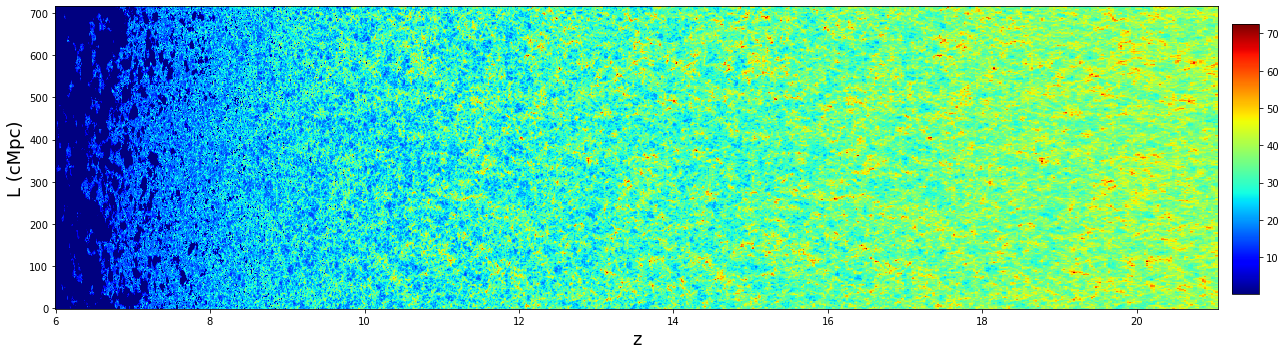

In [21]:
fig, axs = plt.subplots(1,1, figsize=(19, 5))
im = axs.pcolor(redshift, y_Mpc, dTb_lc[0,:,:], cmap='jet')
axs.set_xlabel('z', fontsize=18)
axs.set_ylabel('L (cMpc)', fontsize=18)
# axs.set_xticks(np.arange(6.5,13,1))
# axs.set_yticks(np.arange(0,350,100))
fig.subplots_adjust(bottom=0.11, right=0.91, top=0.95, left=0.06)
cax = plt.axes([0.92, 0.15, 0.02, 0.75])
fig.colorbar(im,cax=cax)
#plt.tight_layout()
plt.show()